# Import dump into MySQL with Python

## Imports and paths

In [1]:
import os
from pathlib import Path
import re
import pandas as pd
import mysql.connector as mysql
import matplotlib.pyplot as plt

In [2]:
home_path = str(Path.home())
os.chdir(home_path + '/git/predwikt/notebooks')

## Starting / Restarting MariaDB after it dies:

### Initialize in bash

**bash**
```bash
service mysqld start
netstat -lnp | grep mysql
```
(I had to use mysqld not mysql: [link](https://stackoverflow.com/questions/11990708/error-cant-connect-to-local-mysql-server-through-socket-var-run-mysqld-mysq))

### ***If no db:*** Drop the incomplete table and put back schema

#### Drop the incomplete table

#### Put create_table_str into memory

#### Recreate the table schema

### Starting mysql.connect

#### Get passwords for mysql.connect

In [5]:
mysql_superuser = 'root'
# mysql_su_pass = input(f'Enter the MySQL password for user {mysql_superuser}: ')
mysql_defaultuser = 'bhrdwj'
# mysql_def_pass = input(f'Enter the MySQL password for user {mysql_defaultuser}: ')

#### Connect mysql.connect and initialize cursor

In [39]:
db_mysql = mysql.connect(
    host = "localhost",
    user = "root",
    passwd = mysql_su_pass,
    database='latest_page' # not the first time around
)
cur_mysql = db_mysql.cursor()

#### Close connection

### Check connection

#### Check current user and schema

In [7]:
cur_mysql.execute('select user();')
print(cur_mysql.fetchall())
cur_mysql.execute('select database();')
print(cur_mysql.fetchall())
cur_mysql.execute('show tables;')
print(cur_mysql.fetchall())

[('root@localhost',)]
[('latest_page',)]
[('page',)]


In [8]:
cur_mysql.execute('DESCRIBE page;')
schema = pd.DataFrame(cur_mysql.fetchall(), columns=['Field','Type','Null','Key','Default','Extra'])
schema

,Field,Type,Null,Key,Default,Extra
0,page_id,int(8) unsigned,NO,PRI,None,auto_increment
1,page_namespace,int(11),NO,MUL,0,
2,page_title,varbinary(255),NO,,,
3,page_restrictions,tinyblob,YES,,None,
4,page_is_redirect,tinyint(1) unsigned,NO,MUL,0,
5,page_is_new,tinyint(1) unsigned,NO,,0,
6,page_random,double unsigned,NO,MUL,0,
7,page_touched,varbinary(14),NO,,None,
8,page_links_updated,varbinary(14),YES,,None,
9,page_latest,int(8) unsigned,NO,,0,


#### Check if table is empty

In [9]:
cur_mysql.execute('SELECT EXISTS(SELECT 1 FROM page);')
cur_mysql.fetchall()

[(1,)]

## Get params of sql dump

### Define EDA functions

#### Function to open a dump

***ONLY USE THIS IN*** ```with open_dump(dump_url) as f:``` ***CONTEXT***

In [13]:
def open_dump(url):
    return open(url, mode='r', encoding='UTF_8', errors='backslashreplace')

dump_url = '../data/raw/enwiki-latest-page.sql'

#### Define a function to get line lengths

In [14]:
def get_line_lengths(dump_url):
    line_lengths = []
    with open_dump(dump_url) as f:
        for line in f:
            line_lengths.append(len(line))
    return line_lengths

#### Define a function to plot line lengths

In [15]:
def plot_line_lengths(ll):
    s = pd.Series(ll, name='line_lengths')
    fig = plt.figure()
    ax = plt.gca()
    s.plot(ax=ax)
    ax.set_xticks([])
    ax.set_xlabel('rows of file')
    ax.set_ylabel('line length')
    plt.show()

### Check dump params

#### Get line lengths and dump length

In [16]:
line_lengths = get_line_lengths(dump_url)
dump_length = len(line_lengths)

#### Plot line lengths

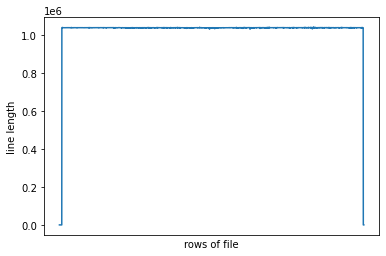

In [17]:
plot_line_lengths(line_lengths)

#### Get start/end row numbers for headers, data, footers

In [18]:
i=0
while line_lengths[i] < 10**4: i+=1
head_last_rownum = i-1
data_first_rownum = i

In [19]:
i=dump_length-100
while line_lengths[i] > 10**4: i+=1
data_last_rownum = i-1
foot_first_rownum = i

### Show start/end row numbers for dump headers, data, footers

In [85]:
(0, head_last_rownum, data_first_rownum, 
    data_last_rownum, foot_first_rownum, dump_length)

(0, 50, 51, 6458, 6459, 6471)

## Import one line of SQL dump

### Check current mysql table

#### Check length of mysql table

In [10]:
cur_mysql.execute('SELECT COUNT(*) FROM page;')
cur_mysql.fetchall()

[(4351549,)]

5m 30s for 104 rows (over)

In [44]:
start_idx = data_first_rownum + 499
end_idx   = start_idx + 502

### Populate one dumpline into mysql very carefully

#### Define a function to get a contiguous slice of rows of dump file

In [26]:
def get_those_rows(start, end, dump_url):
    those_rows = []
    with open_dump(dump_url) as f:
        for i in range(end):
            if i < start:
                f.readline()
            elif i >= start:
                those_rows.append(f.readline())
            else:
                break
    return those_rows

#### Get the next sql dump line

***COULDN'T GET last_dumpline_primary_key*** 
- some values have parentheses inside them.  
- so I need to do a better regex search for last_dumpline_primarykey:
    - I should only find a ( paren that isn't inside quotes.

In [46]:
prev_line = get_those_rows(start_idx-1, start_idx, dump_url)[0]
# last_record_string = re.search(r'(\([^\(]*)(?:;\n)$', prev_line[-500:]).groups()[0]
# last_dumpline_primarykey = int(re.search(r'(?:\()(\d*)',last_record_string).groups()[0])
# last_dumpline_primarykey
prev_line[-500:]

"9133959',75815677,1279,'wikitext',NULL),(6975552,0,'Waziristan_conflict','',1,0,0.6269458882950001,'20211101082700','20191009043147',920342248,46,'wikitext',NULL),(6975553,0,'Hyper_Realism','',1,0,0.393314793479,'20211031073809','20190929134002',459089634,25,'wikitext',NULL),(6975556,3,'Khavall','',0,1,0.459631802275,'20130906111534','20190929134005',75503325,547,'wikitext',NULL),(6975559,1,'Caribou_(train)','',0,0,0.259956602999,'20211028204151','20211028205057',646434731,625,'wikitext',NULL);\n"

In [35]:
last_dumpline_primarykey = 6975559

In [36]:
line_list  = get_those_rows(start_idx, end_idx, dump_url)

#### Replace with REPLACE the INSERT command

In [37]:
line_list = list(map(lambda x: x.replace('INSERT', 'REPLACE', 1), line_list))
line_list[0][:50]

"REPLACE INTO `page` VALUES (6975560,3,'216.162.88."

#### Get final primary key value of mysql table

In [41]:
cur_mysql.execute('SELECT page_id FROM page ORDER BY page_id DESC LIMIT 1;')
last_mysql_primarykey = cur_mysql.fetchall()[0][0]
last_mysql_primarykey

7005237

#### Check if there's a primary key match

*The latest primary key of the mysql table should match the last primary key of the previous sql dump line.*

In [42]:
last_dumpline_primarykey == last_mysql_primarykey

False

### Populate mysql table with dumpfile lines

In [ ]:
for i in range(start_idx, end_idx):
    line = get_those_rows(i, i+1, dump_url)[0]
    cur_mysql.execute(line)
    db_mysql.commit()